test:
1. get embedding
2. get discriminator
3. get off-manifolder
4. get jacobian of the chain
5. visualize jacobians

In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, WDiscriminator
from off_manifolder import offmanifolder1_maker, offmanifolder2_maker
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit, GeodesicBridge
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset

In [11]:
main_sweep_id = '59muwbsf'
# main_disc_sweep_id = 'tadu1xam'
main_disc_sweep_id = 'i7rhrk59'
main_data_name = 'hemisphere_none_0'
main_weights_cycle = 1.
main_dimensions_latent = 3

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = main_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = main_data_name
# run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == main_weights_cycle) & (df['dimensions.latent'] == main_dimensions_latent)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
# cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()
# fig = scatter(zc, s=2, alpha=0.2, title='latent', filename=f'{results_path}/latent.html')
# wandb.log({"latent": wandb.Plotly(fig)})
# fig = scatter(zhh, s=2, alpha=0.2, title='latent_reembedd', filename=f'{results_path}/latent_reembedded.html')
# wandb.log({"latent_reembedded": wandb.Plotly(fig)})
# fig = scatter(x, s=2, alpha=0.2, title='data', filename=f'{results_path}/data.html')
# wandb.log({"data": wandb.Plotly(fig)})
# fig = scatter(xh, s=2, alpha=0.2, title='reconstruction', filename=f'{results_path}/reconstruction.html')
# wandb.log({"reconstruction": wandb.Plotly(fig)})

sweep_id = main_disc_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)
run_ids = df[(df['data.name'] == data_name)][['run_id']]
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_ids.iloc[0].values[0]}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
# cfg.data.root = '../' + cfg.data.root
wd = WDiscriminator.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    wd.eval()
    x_disc = torch.tensor(data['data'], dtype=torch.float32, device=wd.device)
    probab = wd(x_disc).flatten()
    z = model.encoder(x_disc)

# title = f'{data_name} {noise_type} {noise_level} {dist_mask}'
# scatter(zc, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
# scatter(zhh, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
scatter(x_disc, data['mask_x'], s=2, alpha=0.2, title=f'{data_name}: input').show()
scatter(x_disc, probab, s=2, alpha=0.2, title=f'{data_name}: probability').show()#, filename='hsphere_disc_prob.html').show()
scatter(x_disc, probab > 0.5, s=2, alpha=0.2, title=f'{data_name}: classification').show()

# if plot_recon:
#     title = f'[RECON] {title}'
#     if savefolder is not None:
#         filename = f"{savefolder}/{title1}.html"
#     # scatter(xh, data['mask_x'], s=2, alpha=0.2, title=title1, filename=filename).show()


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [12]:
max_prob = probab.max()

(array([  40., 1045.,  242.,  143.,  108.,  127.,  121.,  137.,  130.,
        3407.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

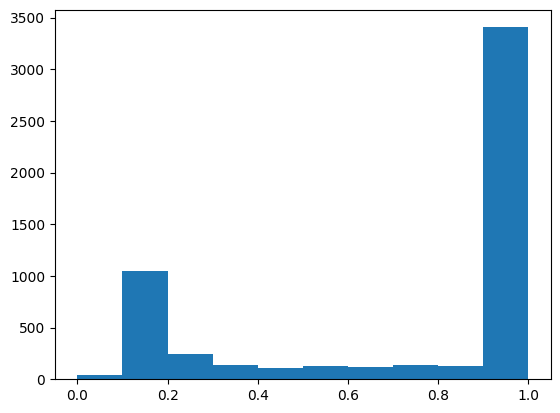

In [13]:
plt.hist((probab-probab.min())/(probab.max()-probab.min()))

In [14]:

xbatch = torch.tensor(data['start_points'], dtype=x.dtype, device=x.device)
xendbatch = torch.tensor(data['end_points'], dtype=x.dtype, device=x.device)

xbatch = model.encoder.preprocessor.normalize(xbatch)
xendbatch = model.encoder.preprocessor.normalize(xendbatch)
ids = torch.zeros((xbatch.size(0),1))

dataset = TensorDataset(xbatch, xendbatch, ids)
dataloader = DataLoader(dataset, batch_size=len(z), shuffle=True)

In [15]:
def offmanifolder5_maker(
    encoder_, 
    discriminator_, 
    disc_factor = 4,
    max_prob=1.
):
    def ofm_(x):
        z = encoder_(x)
        weighting_factor1 = (max_prob-discriminator_(x))/max_prob*disc_factor
        weighting_factor2 = torch.exp(weighting_factor1)
        return torch.cat([z * (weighting_factor2.reshape(-1,1)), (weighting_factor1 * 10).unsqueeze(1).repeat(1, 1)], dim=1)
    return ofm_

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
# disc_func = lambda x: wd(x).flatten()
# disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
# discriminator_func_for_grad = lambda x: wd(x)
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
disc_func = lambda x: (wd(x).flatten()-probab.min())/(probab.max()-probab.min())
disc_func_pen = disc_func
discriminator_func_for_grad = lambda x: (wd(x)-probab.min())/(probab.max()-probab.min())
ofm = offmanifolder5_maker(enc_func, disc_func, disc_factor=3, max_prob=max_prob)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [17]:
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
# gbmodel.lr=1e-3
# # gbmodel.discriminator_func_for_grad_weight=1.
# gbmodel.multiply_loss = True
# trainer = pl.Trainer(
#     max_epochs=400,
#     log_every_n_steps=20,
#     accelerator='cuda',
# )
# trainer.fit(gbmodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-of

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [18]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))/max_prob
discriminator_func_for_grad = lambda x: wd(x)/max_prob
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
# ofm = offmanifolder5_maker(enc_func, disc_func, disc_factor=3, max_prob=max_prob)
gbmodel = GeodesicBridgeOverfit(
    # func=ofm,
    func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=1.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=0.,
)

In [20]:
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
gbmodel.lr=1e-3
gbmodel.discriminator_func_for_grad_weight=1.
gbmodel.multiply_loss = False
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [21]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [22]:
def offmanifolder4_maker(
    encoder_, 
    discriminator_,
    device,
    disc_factor = 4,
    emb_dim=2,
    folding_dim = 10,
):
    random_matrix = torch.randn(emb_dim, folding_dim - emb_dim, device=device, dtype=torch.float32)
    def ofm_(x):
        z = encoder_(x)
        rand_pts = z @ random_matrix
        # weighting_factor = discriminator_(x)*disc_factor
        weighting_factor = torch.exp((1-discriminator_(x))*disc_factor) - 1
        return torch.cat([z, weighting_factor.reshape(-1,1) * rand_pts], dim=1)
    return ofm_

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten() / max_prob
disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
discriminator_func_for_grad = lambda x: wd(x) / max_prob
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder4_maker(enc_func, disc_func, device=device, emb_dim=3, disc_factor=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [24]:
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [25]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
# enc_func = lambda x: model.encoder(x)
enc_func = lambda x: x
disc_func = lambda x: wd(x).flatten() / max_prob
disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
discriminator_func_for_grad = lambda x: wd(x) / max_prob
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder4_maker(enc_func, disc_func, device=device, emb_dim=3, disc_factor=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [27]:
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [28]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [29]:
class OffManifolderLinear():
    """
    Folds points off manifold into higher dimensions using random matrices.
    """
    def __init__(self,
                 X, # n x d points sampled from manifold (in latent space)
                 density_loss_function = None, # function that takes a batch of tensors as input, and outputs a scalar which is 0 on the manifold, and bigger further away.
                 folding_dim = 10,
                 density_k = 5,
                 density_tol = 0.1,
                 density_exponential = 4, 
                 # modify to pass in density_loss
                ):
        self.X = X
        self.device = X.device
        self.dim = X.shape[1]
        self.folding_dim = folding_dim
        self.density_k = density_k
        self.density_tol = density_tol
        self.density_exponential = density_exponential
        self.density_loss_function = density_loss_function
        
        self.preserve_matrix = torch.zeros(self.dim, self.folding_dim, dtype=torch.float).to(self.device)
        for i in range(self.dim):
            self.preserve_matrix[i,i] = 1.0

        self.random_matrix = torch.randn(self.dim, self.folding_dim).to(self.device)
        self.random_matrix[:self.dim, :self.dim] = torch.zeros(self.dim, self.dim).to(self.device)
        # self.random_layer = torch.nn.Linear(self.dim, self.folding_dim)

    def _1density_loss(self, a):
        # 0 for points on manifold within tolerance. Designed for a single point.
        dists = torch.linalg.norm(self.X - a, axis=1)
        smallest_k_dists, idxs = torch.topk(dists, self.density_k, largest=False) # return k smallest distances
        loss = torch.sum(
            torch.nn.functional.relu( smallest_k_dists - self.density_tol )
        )
        return loss
    def density_loss(self, points):
        if self.density_loss_function is not None:
            return self.density_loss_function(points)
        else:
            return torch.vmap(self._1density_loss)(points)

    def immersion(self, points):
        preserved_subspace = points @ self.preserve_matrix
        random_dirs = points @ self.random_matrix
        # random_dirs = self.random_layer(points)
        weighting_factor = torch.exp(self.density_loss(points)*self.density_exponential) - 1 # starts at 1; gets higher immediately.
        return preserved_subspace + random_dirs*weighting_factor[:,None]

    def pullback_metric(self, points):
        if not isinstance(points, torch.Tensor): points = torch.tensor(points, dtype=torch.float)
        jac = torch.func.jacrev(self.immersion, argnums = 0) #(points)
        def pullback_per_point(p):
            print(p)
            print(p.shape)
            J = jac(p[None,:])
            J = torch.squeeze(J)
            print("shape J", J.shape)
            return J.T @ J
        return torch.vmap(pullback_per_point)(points)


In [30]:
ofmr = OffManifolderLinear(X=x)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
# enc_func = lambda x: model.encoder(x)
enc_func = lambda x: x
disc_func = lambda x: wd(x).flatten() / max_prob
# disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
# discriminator_func_for_grad = lambda x: wd(x) / max_prob
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
# ofm = offmanifolder4_maker(enc_func, disc_func, device=device, emb_dim=3, disc_factor=3)
ofm = ofmr.immersion
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func_pen,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [32]:
gbmodel.lr=1e-2
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [33]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
# disc_func = lambda x: wd(x).flatten()/max_prob
# disc_func_pen = lambda x: 1 - (1 - disc_func(x))
# discriminator_func_for_grad = lambda x: wd(x)/max_prob
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
disc_func = lambda x: (wd(x).flatten()-probab.min())/(probab.max()-probab.min())
disc_func_pen = disc_func
discriminator_func_for_grad = lambda x: (wd(x)-probab.min())/(probab.max()-probab.min())
ofm = offmanifolder5_maker(enc_func, disc_func, disc_factor=3, max_prob=max_prob)
gbmodel = GeodesicBridgeOverfit(
    # func=ofm,
    func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=1.,
    discriminator_func_for_grad_weight=10.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [35]:
gbmodel.lr=1e-3
gbmodel.discriminator_func_for_grad_weight=0.
gbmodel.discriminator_weight=10.
gbmodel.length_weight=0.
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
# gbmodel.lr=1e-4
# gbmodel.discriminator_func_for_grad_weight=1.
# gbmodel.discriminator_weight=10.
# gbmodel.length_weight=0.
# # gbmodel.multiply_loss=True
# trainer = pl.Trainer(
#     max_epochs=400,
#     log_every_n_steps=20,
#     accelerator='cuda',
# )
# trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [36]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [37]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts, ids)
    xconc = xhat.flatten(0, 1)
    probs = disc_func(xconc)
scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2)

In [38]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
with torch.no_grad():
    xconc = x_disc.to(device)
    probs = disc_func(xconc)
scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2)
scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2)